In [25]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [26]:
trans = transforms.Compose([
    transforms.ToTensor(),  #it is like numpy array for pytorch  
    transforms.Normalize((0.5,), (0.5,))  #this normalizes the data between -1 and 1
])
#download the data
train_data = datasets.MNIST(
    root="./data",
    train=True,
    transform=trans,
)
test_data = datasets.MNIST(
    root="./data",
    transform=trans,
    train=False,
)
#print the length of the data
print(len(train_data))
print(len(test_data))


60000
10000


In [27]:
#split the data into train and validation using sklearn
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data.targets)
print(len(train_data))
print(len(val_data))

48000
12000


In [28]:
#load the data using dataloader
#what does data loder do?it loads the data in batches-it shuffles the data-it makes the data iterable
#what is the batch size?it is the number of samples that will be passed through the network at once
#what is shuffle?it shuffles the data so that the model will not learn the order of the data
batch_sz = 16
train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_sz, shuffle=True)

In [29]:
print(len(train_loader))
#750 is the number of batches it came from 48000(the length of the train dataset)/64=750 
print(len(val_loader))
#188 is the number of batches it came from 12000(the length of the validation dataset)/64=188
print(len(test_loader))
#157 is the number of batches it came from 10000(the length of the test dataset)/64=157

3000
750
625


In [30]:
import torch.nn as n
from torch import optim

In [31]:
class neural_model(n.Module):
    def __init__(self, lr):
        super().__init__()
        self.layers = n.Sequential(
            n.Flatten(),
            n.Linear(28 * 28, 400),  #input layer_input=28*28=784 output layer_input=200
            n.LayerNorm(400),  # Layer Normalization to speed up the training process
            n.Dropout(0.5),  #droping out the unwanted overfiting features
            n.ReLU(),
            n.Linear(400, 200),  #input h_layer_1=200 output h_layer_2=100
            n.ReLU(),
            n.Linear(200, 100),  #input h_layer_2=200 output h_layer_2=100
            n.ReLU(),
            n.Linear(100, 10),  #input output_layer=100 output output_layer=10
        )
        self.loss = n.CrossEntropyLoss()
        self.learning_rate = lr
        self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        x = self.layers(x)
        return x

    def fit(self, x, y):
        self.optimizer.zero_grad()  #this is to reset the gradients to zero
        y_output = self.forward(x)  #this is to get the predictions
        loss = self.loss(y_output, y)  #this is to get the loss
        loss.backward()  #this is to backpropagate the loss
        self.optimizer.step()  #this is to update the weights
        return loss.item()  #this is to return the loss

    def predict(self, x):
        with torch.no_grad():
            output = self.forward(x)
            _, predicted = torch.max(output, 1)
        return predicted



In [32]:
model = neural_model(0.01)

In [33]:
#train the model
epochs = 5
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    model.eval()
    for x, y in train_loader:
        train_loss += model.fit(x, y)
        train_accuracy += torch.sum(model.predict(x) == y).item()

    train_losses.append(train_loss / len(train_loader))
    train_acc.append(train_accuracy / len(train_data))
    for x, y in val_loader:
        val_loss += model.fit(x, y)
        val_accuracy += torch.sum(model.predict(x) == y).item()
    val_losses.append(val_loss / len(val_loader))
    val_acc.append(val_accuracy / len(val_data))
    print(
        f"Epoch {epoch + 1}/{epochs}.. "
        f"Train loss: {train_losses[-1]:.3f}.. "
        f"Val loss: {val_losses[-1]:.3f}.. "
        f"Train accuracy: {train_acc[-1]:.3f}.. "
        f"Val accuracy: {val_acc[-1]:.3f}"
    )


Epoch 1/5.. Train loss: 0.503.. Val loss: 0.207.. Train accuracy: 0.926.. Val accuracy: 0.989
Epoch 2/5.. Train loss: 0.160.. Val loss: 0.135.. Train accuracy: 0.993.. Val accuracy: 0.995
Epoch 3/5.. Train loss: 0.115.. Val loss: 0.099.. Train accuracy: 0.996.. Val accuracy: 0.996
Epoch 4/5.. Train loss: 0.091.. Val loss: 0.084.. Train accuracy: 0.997.. Val accuracy: 0.997
Epoch 5/5.. Train loss: 0.077.. Val loss: 0.071.. Train accuracy: 0.998.. Val accuracy: 0.998


Predicted Label: [0]
True Label: [0]


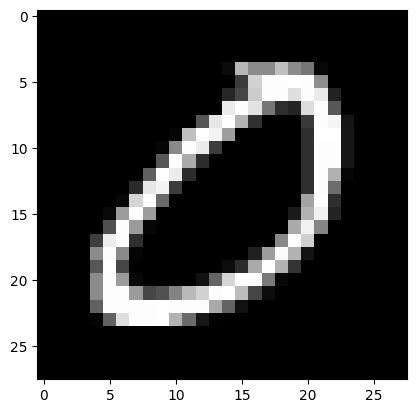

In [34]:
from matplotlib import pyplot as plt
import numpy as np
model.eval()

i = np.random.randint(0, len(test_data))



with torch.no_grad():
    input = test_data[i][0].unsqueeze(0).to('cpu')

    output = model.forward(input)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()

print("Predicted Label:", [output[0]])
print("True Label:", [test_data[i][1]])

plt.imshow(input.squeeze().cpu().numpy(), cmap='gray')  # Show the input image as grayscale
plt.show()

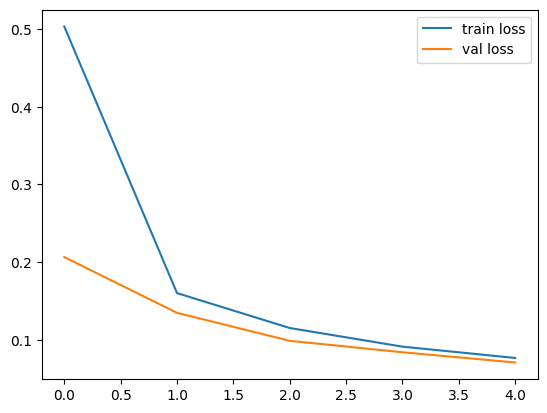

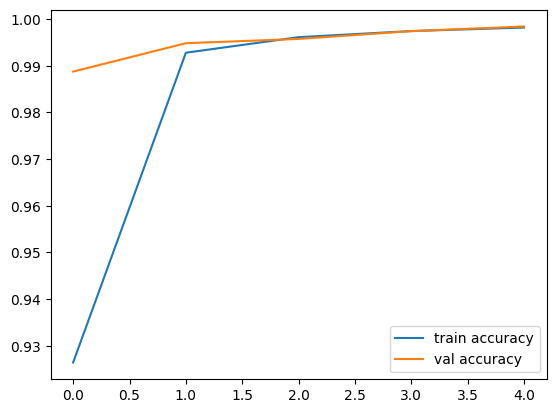

In [35]:
# #plot the losses - the loss should decrease
# #plot the accuracy - the accuracy should increase
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()
plt.plot(train_acc, label="train accuracy")
plt.plot(val_acc, label="val accuracy")
plt.legend()
plt.show()

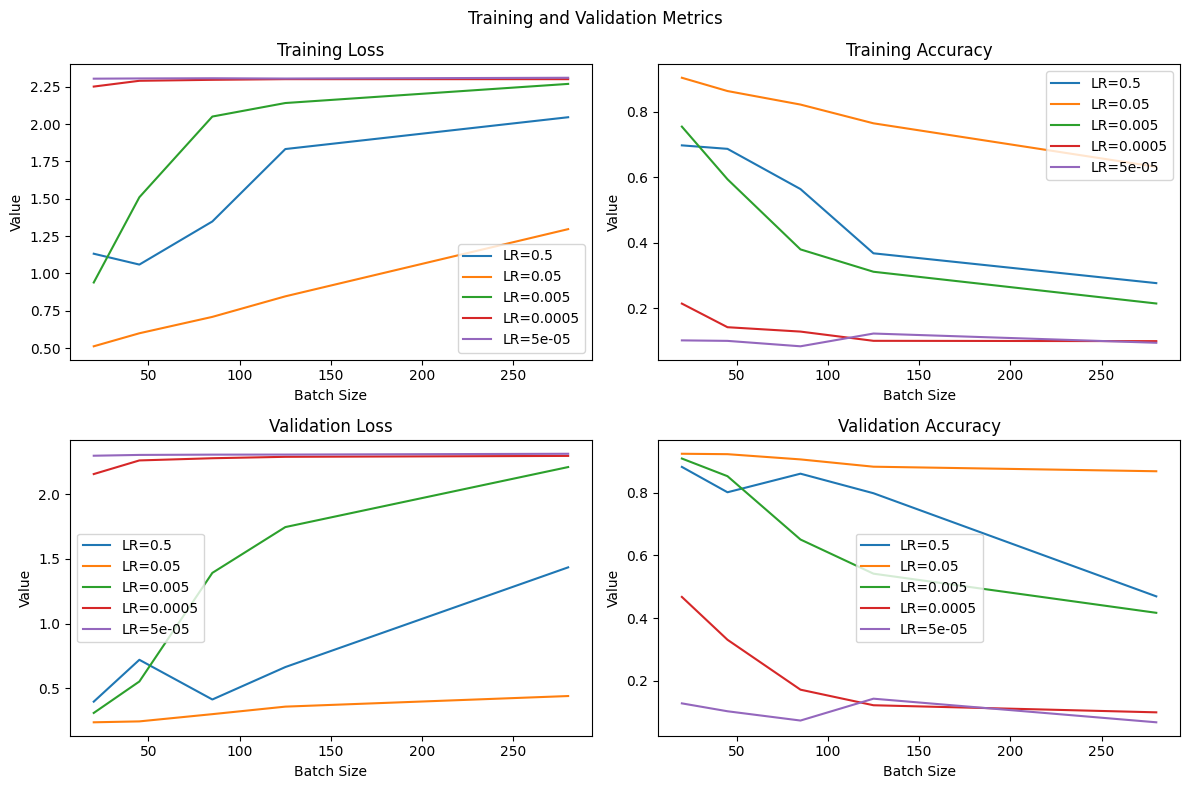

In [36]:
import matplotlib.pyplot as plt

learning_rates = [0.5, 0.05, 0.005, 0.0005, 0.00005]
batch_sizes = [20, 45, 85, 125, 280]
results = []

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for lr in learning_rates:
    for b in batch_sizes:
        # ... (previous code remains the same)
        model = neural_model(lr)
        train_loss = 0
        val_loss = 0
        train_correct = 0
        val_correct = 0

        train_loader = DataLoader(train_data, batch_size=b, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=b, shuffle=False)

        for x, y in train_loader:
            train_loss += model.fit(x, y)
            y_pred = model.predict(x)
            train_correct += torch.sum(y_pred == y).item()

        train_loss /= len(train_loader)
        train_accuracy = train_correct / len(train_data)

        model.eval()
        with torch.no_grad():
            for x_val, y_val in val_loader:
                output_val = model.forward(x_val)
                val_loss += model.loss(output_val, y_val).item()
                y_pred_val = model.predict(x_val)
                val_correct += torch.sum(y_pred_val == y_val).item()

            val_loss = val_loss / (len(val_loader))
            val_accuracy = (val_correct / len(val_data)) 


        # Store values in lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # append results to list of dictionaries for printing
        results.append({
            'learning_rate': lr,
            'batch_size': b,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })

# Reshape lists for plotting
train_losses = [train_losses[i:i + len(batch_sizes)] for i in range(0, len(train_losses), len(batch_sizes))]
train_accuracies = [train_accuracies[i:i + len(batch_sizes)] for i in range(0, len(train_accuracies), len(batch_sizes))]
val_losses = [val_losses[i:i + len(batch_sizes)] for i in range(0, len(val_losses), len(batch_sizes))]
val_accuracies = [val_accuracies[i:i + len(batch_sizes)] for i in range(0, len(val_accuracies), len(batch_sizes))]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Training and Validation Metrics')

for i in range(len(learning_rates)):
    axs[0, 0].plot(batch_sizes, train_losses[i], label=f"LR={learning_rates[i]}")
    axs[0, 0].set_title('Training Loss')
    axs[0, 1].plot(batch_sizes, train_accuracies[i], label=f"LR={learning_rates[i]}")
    axs[0, 1].set_title('Training Accuracy')
    axs[1, 0].plot(batch_sizes, val_losses[i], label=f"LR={learning_rates[i]}")
    axs[1, 0].set_title('Validation Loss')
    axs[1, 1].plot(batch_sizes, val_accuracies[i], label=f"LR={learning_rates[i]}")
    axs[1, 1].set_title('Validation Accuracy')

for ax in axs.flat:
    ax.set(xlabel='Batch Size', ylabel='Value')
    ax.legend()

plt.tight_layout()
plt.show()


In [37]:
#print statment of the results
for result in results:
     print(f"lr: {result['learning_rate']}, batch size: {result['batch_size']}, train loss: {result['train_loss']}, train accuracy: {result['train_accuracy']} ") 
     print(f"lr: {result['learning_rate']}, batch size: {result['batch_size']}, val loss: {result['val_loss']}, val accuracy: {result['val_accuracy']} ")
     print("-------------------------------------------------")


lr: 0.5, batch size: 20, train loss: 1.132073812043915, train accuracy: 0.6968541666666667 
lr: 0.5, batch size: 20, val loss: 0.3984491129498929, val accuracy: 0.8823333333333333 
-------------------------------------------------
lr: 0.5, batch size: 45, train loss: 1.0594208303912287, train accuracy: 0.6862291666666667 
lr: 0.5, batch size: 45, val loss: 0.721338826004932, val accuracy: 0.8015 
-------------------------------------------------
lr: 0.5, batch size: 85, train loss: 1.348118318393167, train accuracy: 0.563625 
lr: 0.5, batch size: 85, val loss: 0.41510405790218163, val accuracy: 0.86075 
-------------------------------------------------
lr: 0.5, batch size: 125, train loss: 1.8329700347967446, train accuracy: 0.36783333333333335 
lr: 0.5, batch size: 125, val loss: 0.6652768508841594, val accuracy: 0.7984166666666667 
-------------------------------------------------
lr: 0.5, batch size: 280, train loss: 2.045982018459675, train accuracy: 0.2769583333333333 
lr: 0.5, ba

#  insights 
in this project working with neural networks we concluded the following:
to prevent overfitting we need to work on finding the best learning rate "lr" which for us was 0.05 with validation accuracy of 91% 
to even give it a further boost we used a dropout layer set to "0.5" to drop the unnecarry features causing overfitting, new accuracy jumped to 93%
unnecessary*
## here what we used:
- used layer normalization to speed up the training process
- used relu activation function to speed up the training process
- used softmax activation function to get the probabilities of the output layer
- used cross entropy loss function to calculate the loss
- used stochastic gradient descent optimizer to update the weights
- used the dataloader to load the data in batches
- used the train_test_split to split the data into train and validation